IMPORT PACKAGES

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import pickle

READ DATA

In [3]:
df_data = pd.read_csv("adult.csv")
df_data.head()

,age,workclass,fnlwgt,education,educationalnum,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


CHECK DATA


In [4]:
df_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
educationalnum     int64
maritalstatus     object
occupation        object
relationship      object
race              object
gender            object
capitalgain        int64
capitalloss        int64
hoursperweek       int64
nativecountry     object
income            object
dtype: object

In [5]:
df_data["nativecountry"].value_counts().index[0]

' United-States'

In [6]:
df_data["income"].value_counts()

income
 <=50K    24720
 >50K      7841
Name: count, dtype: int64

In [22]:
col_names = df_data.columns
print(col_names)

Index(['age', 'workclass', 'education', 'maritalstatus', 'occupation',
       'relationship', 'race', 'gender', 'capitalgain', 'capitalloss',
       'hoursperweek', 'nativecountry', 'income'],
      dtype='object')


Check Nulls and replace values

In [23]:
for c in col_names:
    df_data = df_data.replace("?", np.NaN)
df_data = df_data.apply(lambda x:x.fillna(x.value_counts().index[0]))

ENCODING

In [24]:
category_col =['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'gender', 'nativecountry', 'income']
lbl_data = df_data.copy()
df_input = df_data[category_col].copy()
enc = preprocessing.LabelEncoder()
encoder_dict = dict()
for cat in category_col:
    df_input[cat] = df_input[cat].str.lstrip()
    enc = enc.fit(list(df_input[cat]) + ['Unknown'])
    encoder_dict[cat] = [cat for cat in enc.classes_]
    lbl_data[cat] = enc.transform(df_input[cat])

In [25]:
lbl_data.head()

,age,workclass,education,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,39,7,9,4,1,1,5,1,2174,0,40,39,0
1,50,6,9,2,4,0,5,1,0,0,13,39,0
2,38,4,11,0,6,1,5,1,0,0,40,39,0
3,53,4,1,2,6,0,2,1,0,0,40,39,0
4,28,4,9,2,10,6,2,0,0,0,40,5,0


Save LABEL ENCODER

In [26]:
encoder_pickle_out = open("encoder.pkl", "wb")
pickle.dump(encoder_dict, encoder_pickle_out)
encoder_pickle_out.close()

In [44]:
print(encoder_dict)

{'workclass': ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Unknown', 'Without-pay'], 'education': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college', 'Unknown'], 'maritalstatus': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Unknown', 'Widowed'], 'occupation': ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving', 'Unknown'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unknown', 'Unmarried', 'Wife'], 'race': ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'Unknown', 'White'], 'gender': 

Exploratory Data Analysis

Text(0.5, 1.0, '<=50K Income vs >50K Income Count')

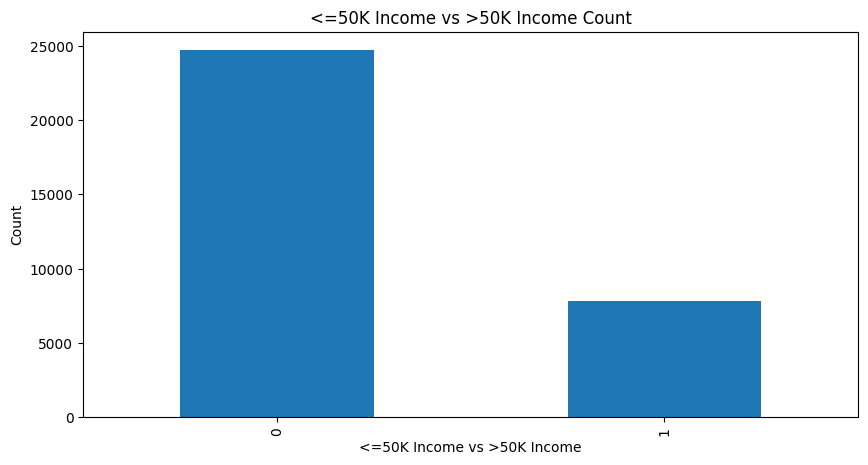

In [27]:
# Plot Income <=50k and >50k
plt.figure(figsize=(10,5))
ax = lbl_data.income.value_counts().plot(kind = 'bar')
plt.xlabel("<=50K Income vs >50K Income")
plt.ylabel("Count")
plt.title("<=50K Income vs >50K Income Count")

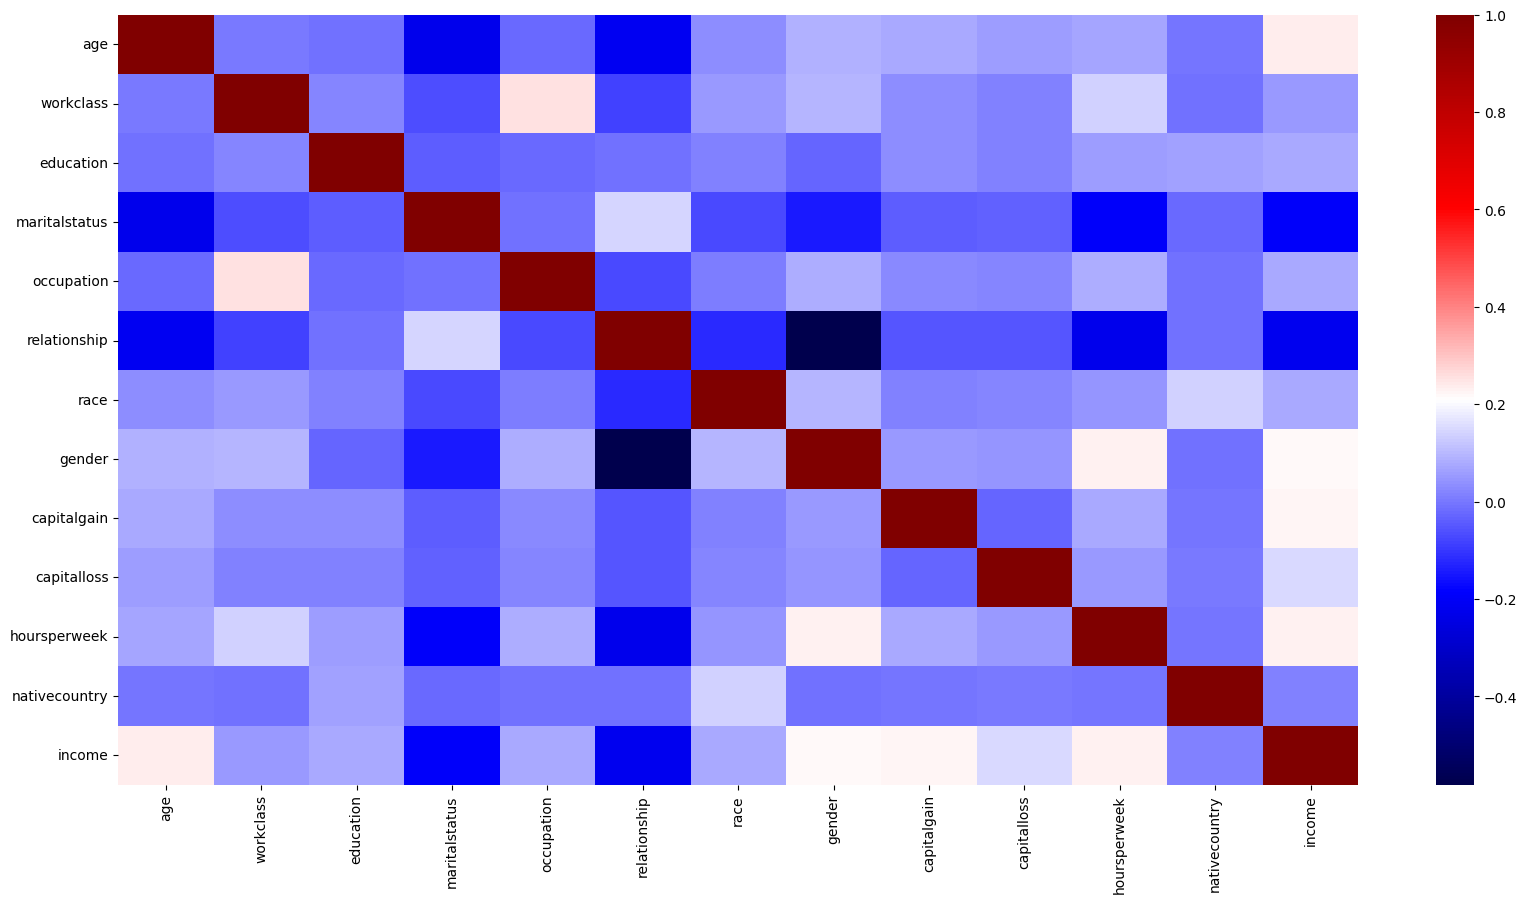

In [28]:
# Heatmap to find any high correlations
plt.figure(figsize=(20,10))
sns.heatmap(data=lbl_data.corr(), cmap="seismic")
plt.show()

LABEL DATA

In [29]:
X = lbl_data.drop('income', axis = 1)
Y = lbl_data['income']

Cluster data using Dimensionality reduction

In [30]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X.values)

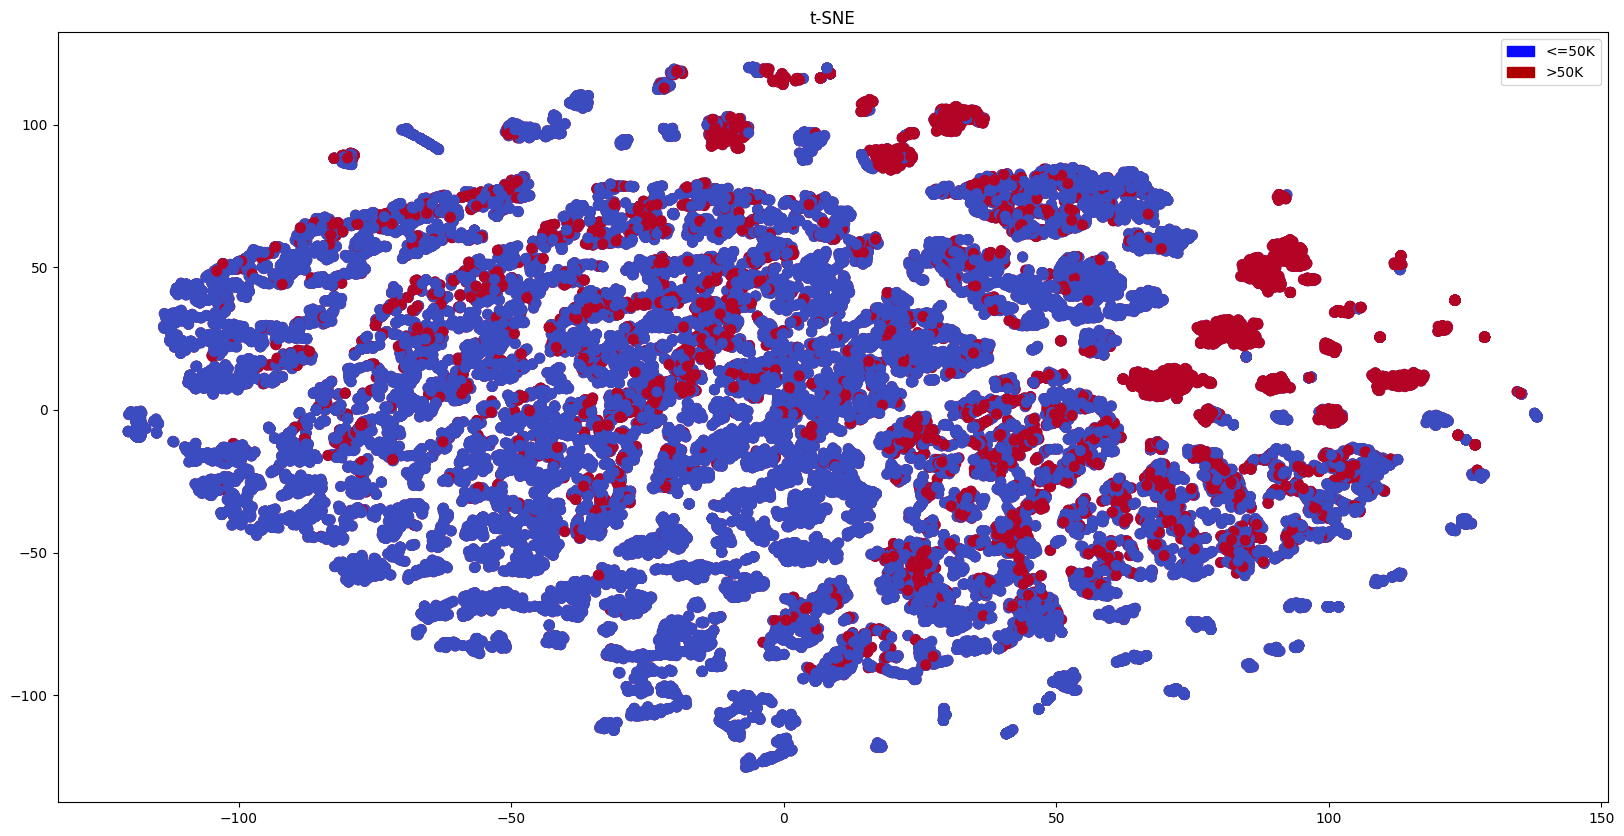

In [31]:
blue_patch = mpatches.Patch(color='#0A0AFF', label='<=50K')
red_patch = mpatches.Patch(color='#AF0000', label='>50K')
plt.figure(figsize=(20,10))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(Y == 0), cmap='coolwarm', label='<=50K', linewidths=2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(Y == 1), cmap='coolwarm', label='>50K', linewidths=2)
plt.title('t-SNE')
plt.legend(handles=[blue_patch, red_patch])

Split into train and test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)

Train & Test Data using Random Forest

In [33]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
rf_fp, rf_tp, rf_threshold = roc_curve(y_test, ypred)
print("Threshold:", rf_threshold)

[[6866  562]
 [ 890 1451]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7428
           1       0.72      0.62      0.67      2341

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769

Accuracy Score: 0.8513665677141979
Recall Score: 0.6198205894916702
Precision Score: 0.7208147044212618
ROC AUC Score:  0.7720804616817534
Threshold: [2 1 0]


Train & Test Data using Gradient Boosting Classifier

In [34]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbc.fit(X_train, y_train)
ypred = gbc.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
gbc_fp, gbc_tp, gbc_threshold = roc_curve(y_test, ypred)
print("Threshold:", gbc_threshold)

[[7035  393]
 [ 905 1436]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7428
           1       0.79      0.61      0.69      2341

    accuracy                           0.87      9769
   macro avg       0.84      0.78      0.80      9769
weighted avg       0.86      0.87      0.86      9769

Accuracy Score: 0.8671307196232982
Recall Score: 0.6134130713370355
Precision Score: 0.7851284855112083
ROC AUC Score:  0.7802525776717487
Threshold: [2 1 0]


Train & Test Data using Ada Boost Classifier

In [35]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
abc.fit(X_train, y_train)
ypred = abc.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
abc_fp, abc_tp, abc_threshold = roc_curve(y_test, ypred)
print("Threshold:", abc_threshold)

[[6980  448]
 [ 884 1457]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      7428
           1       0.76      0.62      0.69      2341

    accuracy                           0.86      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769

Accuracy Score: 0.8636503224485618
Recall Score: 0.6223835967535242
Precision Score: 0.7648293963254593
ROC AUC Score:  0.7810356325178498
Threshold: [2 1 0]


ROC Curve

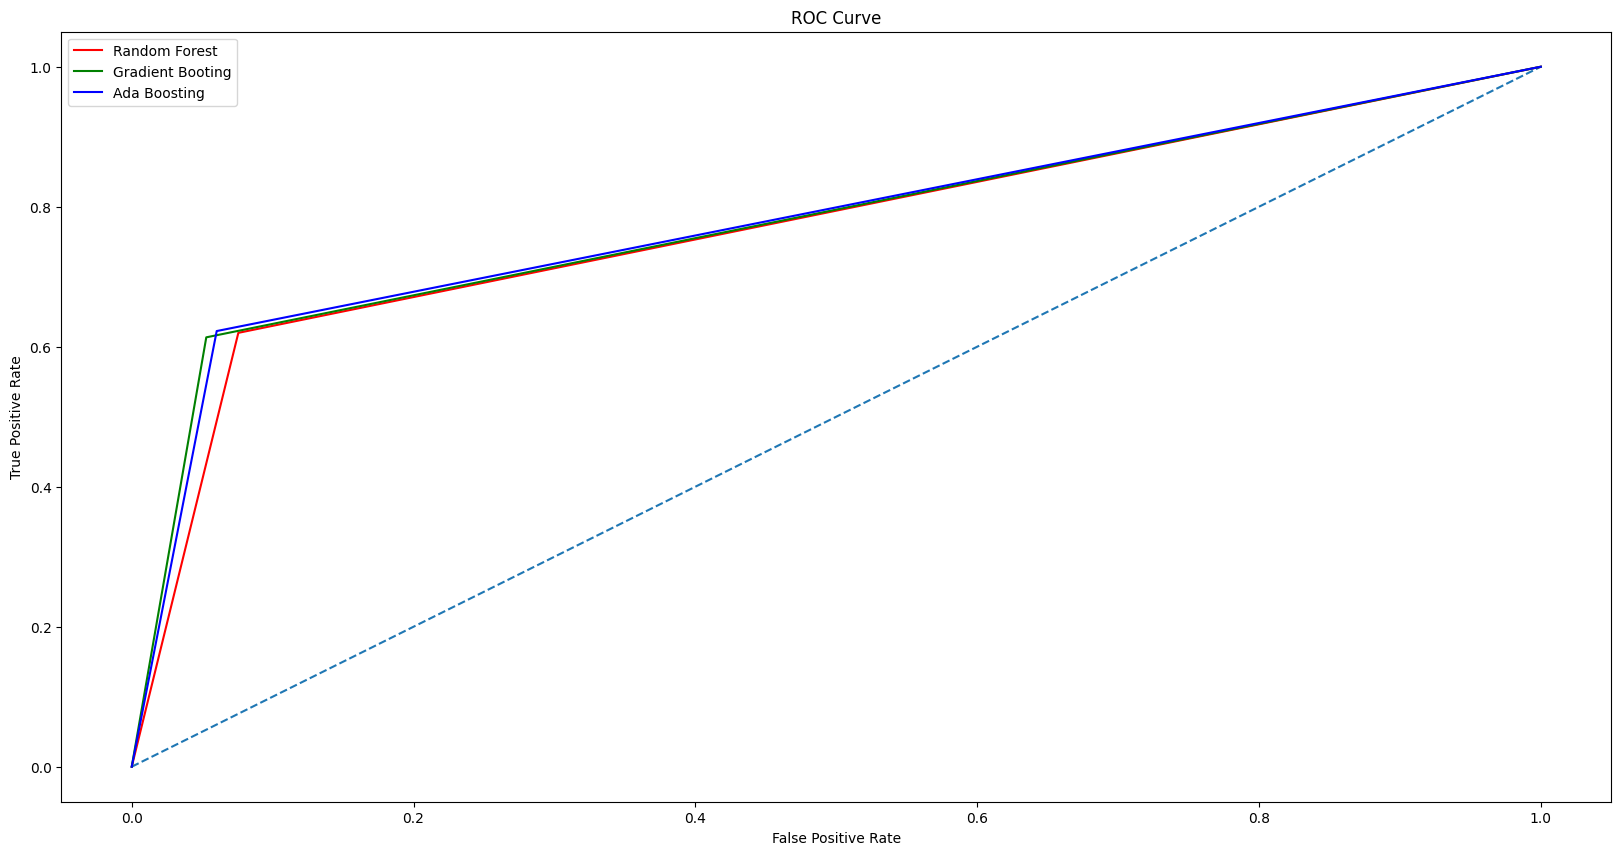

In [36]:
plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(rf_fp, rf_tp, color="red", label = "Random Forest")
plt.plot(gbc_fp, gbc_tp, color="green", label = "Gradient Booting")
plt.plot(abc_fp, abc_tp, color="blue", label = "Ada Boosting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

Get most important features and their contribution in model

In [37]:
feature_importance_df = pd.DataFrame(X_train.columns, columns=["Feature"])
feature_importance_df["Importance"] = rf.feature_importances_
feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.head(20)
feature_importance_df

,Feature,Importance
0,age,0.224647
8,capitalgain,0.130645
5,relationship,0.114418
10,hoursperweek,0.112314
2,education,0.102435
4,occupation,0.094305
3,maritalstatus,0.068784
1,workclass,0.052675
9,capitalloss,0.045608
11,nativecountry,0.021752


SAVE MODEL

In [38]:
pickle_out = open("model.pkl", "wb")
pickle.dump(gbc, pickle_out)
pickle_out.close()

TEST MODEL

In [39]:
pkl_file = open('encoder.pkl', 'rb')
encoder_dict = pickle.load(pkl_file)
pkl_file.close()

In [40]:
print(encoder_dict)

{'workclass': ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Unknown', 'Without-pay'], 'education': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college', 'Unknown'], 'maritalstatus': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Unknown', 'Widowed'], 'occupation': ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving', 'Unknown'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unknown', 'Unmarried', 'Wife'], 'race': ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'Unknown', 'White'], 'gender': 

In [48]:
from sklearn import preprocessing
import pandas as pd

# Mengganti nilai "?" dengan NaN
df.replace("?", np.NaN, inplace=True)

# Membuat salinan DataFrame
df_copy = df.copy()

# Mendefinisikan kolom-kolom kategorikal
category_col = ['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'gender', 'nativecountry']

# Membuat LabelEncoder untuk setiap kolom kategorikal
encoder_dict = {}
for col in category_col:
    le = preprocessing.LabelEncoder()
    # Mengganti nilai-nilai yang tidak dikenali dengan "Unknown"
    df[col] = df[col].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
    # Fitting dan transforming LabelEncoder pada kolom
    df[col] = le.fit_transform(df[col])
    # Menyimpan kelas-kelas LabelEncoder dalam kamus
    encoder_dict[col] = le.classes_

# Menyimpan kamus encoder ke dalam file
import pickle
with open("encoder.pkl", "wb") as encoder_pickle_out:
    pickle.dump(encoder_dict, encoder_pickle_out)


In [49]:
features_list = df.values.tolist()
prediction = gbc.predict(features_list)
print(prediction[0])

1
